In [1]:
import sys
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

sys.path.append("./lib")

device = torch.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

### Step 1: Loading the model

We prepared our custom Steam dataset with over 80,000 games and corresponding images for each of them. We can read this dataset from the `data` directory.

In [2]:
import steam.loaders.genre_classification

from pathlib import Path

dataset, metadata = steam.loaders.genre_classification.load(
    steam_games=Path("./data/steam/games.json"),
    top_n_by_popularity=5000,
)

dataset["train"].data.head()

,id,title,image,genres,Action,Adventure,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
1262,1118010,Monster Hunter World: Iceborne,images/1118010/ss_4d98c381f7038b0c0efe5e2425e2...,[Action],1,0,0,0,0,0,0,0,0,0,0,0
979,1313140,Cult of the Lamb,images/1313140/ss_b26625d6f64a739ed1ddf832a5d2...,"[Action, Adventure, Indie, Strategy]",1,1,0,0,0,1,0,0,0,0,0,1
792,578080,PUBG: BATTLEGROUNDS,images/578080/ss_8814c071f0cce53821d8e1b1a96de...,"[Action, Adventure, Massively Multiplayer, Fre...",1,1,0,0,1,0,1,0,0,0,0,0
1433,518790,theHunter: Call of the Wild™,images/518790/ss_39c535f3ea0805ba8f8cc58039c4b...,"[Adventure, Simulation, Sports]",0,1,0,0,0,0,0,0,0,1,1,0
374,1966720,Lethal Company,images/1966720/ss_568d97dfa9d8d3128157d84c9437...,"[Action, Adventure, Indie, Early Access]",1,1,0,1,0,1,0,0,0,0,0,0


Let's define a few convenience functions to easily get an image for a given game:

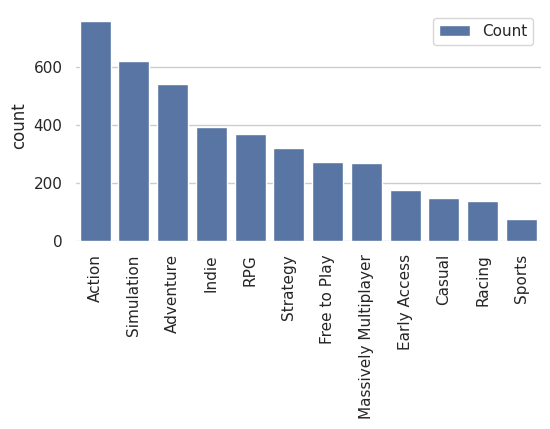

In [3]:
f, ax = plt.subplots(figsize=(6, 3))

sns.barplot(y="count", x="genres", data=metadata.genre_counts, label="Count")
sns.despine(left=True, bottom=True)
ax.set(xlabel="")
ax.tick_params(axis="x", rotation=90)

In [4]:
import typing
from transformers import BitImageProcessor, BitsAndBytesConfig
from peft import LoraConfig, LoftQConfig, get_peft_model, prepare_model_for_kbit_training
from steam.models import DinoV2ForImbalancedImageClassification

model_id = "facebook/dinov2-base"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

image_processor = typing.cast(BitImageProcessor, BitImageProcessor.from_pretrained(model_id))
base_model = typing.cast(DinoV2ForImbalancedImageClassification, DinoV2ForImbalancedImageClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(metadata.id2label),
    id2label=metadata.id2label,
    label2id=metadata.label2id,
    label_weights=metadata.label_weights,
    # quantization_config=bnb_config,
    # low_cpu_mem_usage=True,
))
# base_model = prepare_model_for_kbit_training(base_model)

loftq_config = LoftQConfig(loftq_bits=4)
config = LoraConfig(
    r=64,
    lora_alpha=64,
    target_modules="all-linear",
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
    init_lora_weights="loftq",
    loftq_config=loftq_config,
)
model = get_peft_model(base_model, config)
model.print_trainable_parameters()
model.to(device)


Some weights of DinoV2ForImbalancedImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 10,635,276 || all params: 97,234,200 || trainable%: 10.937793492413164


PeftModel(
  (base_model): LoraModel(
    (model): DinoV2ForImbalancedImageClassification(
      (dinov2): Dinov2Model(
        (embeddings): Dinov2Embeddings(
          (patch_embeddings): Dinov2PatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): Dinov2Encoder(
          (layer): ModuleList(
            (0-11): 12 x Dinov2Layer(
              (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
              (attention): Dinov2Attention(
                (attention): Dinov2SelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, o

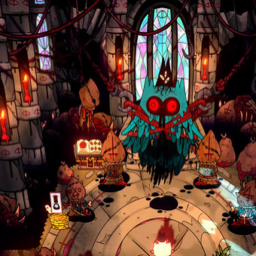

In [5]:
import PIL.Image
import numpy as np

from torchvision.transforms import v2

size = image_processor.size["shortest_edge"]
mean = typing.cast(list[float], image_processor.image_mean)
std = typing.cast(list[float], image_processor.image_std)

transform = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(size,size), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

dataset["train"].set_transform(transform)
dataset["test"].set_transform(transform)

# Denormalize the pixel values to see that the image is also correctly loaded
def inverse_transform(pixel_values: torch.Tensor) -> PIL.Image.Image:
    unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return PIL.Image.fromarray(unnormalized_image)

inverse_transform(dataset["train"][1]["pixel_values"])

In [6]:
from transformers import TrainingArguments, Trainer, EvalPrediction, IntervalStrategy
from steam.metrics.multi_label import create_multi_label_metrics

metrics = create_multi_label_metrics(positive_label_threshold=metadata.positive_label_threshold)

def data_collator(batch: list[dict[str, torch.Tensor]]):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return { "pixel_values": pixel_values, "labels": labels }

def compute_metrics(p: EvalPrediction):
    predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    labels = p.label_ids[0] if isinstance(p.label_ids, tuple) else p.label_ids
    result = metrics(predictions=predictions, labels=labels)
    return result

training_args = TrainingArguments(
    output_dir="./data/steam_genre_classifier",
    remove_unused_columns=False,
    evaluation_strategy=IntervalStrategy.STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_total_limit=10,
    eval_steps=200,
    save_steps=200,
    learning_rate=5e-5,
    weight_decay=0.01,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=20,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    label_names=["labels"],
    tf32=True,
    bf16=True,
    optim="adamw_bnb_8bit",
    auto_find_batch_size=True,
    # torch_compile=True,
    # torch_compile_backend="inductor",
    # torch_compile_mode="reduce-overhead"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()